# Brain Tumor Detector

## Get and Load Dataset

In [1]:
!pip install --upgrade --no-cache-dir gdown

In [2]:
!gdown --id 1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj

/home/constructor/anaconda3/envs/DLG/lib/python3.11/site-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj
From (redirected): https://drive.google.com/uc?id=1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj&confirm=t&uuid=da6787ce-12e0-4ef9-a678-1fd2f8c6c7dc
To: /home/constructor/gammer_exercises/DL_group_challenge/brain_tumor.zip
100%|████████████████████████████████████████| 156M/156M [00:13<00:00, 11.5MB/s]


In [4]:
!pip install unzip

In [7]:
#!unzip brain_tumor.zip

/bin/bash: line 1: unzip: command not found


In [8]:
ls -l

total 152496
-rw-r--r-- 1 constructor constructor        50 Apr  4 10:17 Brain_Tumor_Detector_Helper.ipynb:Zone.Identifier
-rw-r--r-- 1 constructor constructor    348977 Apr  4 10:22 Brain_Tumor_Detector_gammer.ipynb
drwxr-xr-x 6 constructor constructor      4096 Apr  4 10:24 Testing/
drwxr-xr-x 6 constructor constructor      4096 Apr  4 10:29 Training/
-rw-r--r-- 1 constructor constructor 155791278 Apr  4 10:20 brain_tumor.zip


In [9]:
!sudo apt-get install tree #just to see folder structures, run only on linux systems like colab

[sudo] password for constructor: 


In [11]:
!tree --dirsfirst --filelimit 4 ./Training/ #just to see folder structures, run only on linux systems like colab

/bin/bash: line 1: tree: command not found


In [12]:
!tree --dirsfirst --filelimit 4 ./Testing/ #just to see folder structures, run only on linux systems like colab

/bin/bash: line 1: tree: command not found


## Load Dependencies

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix,\
                            classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

print('TF Version:', tf.__version__)

2024-04-04 10:48:08.501292: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-04 10:48:08.526893: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 10:48:08.526909: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 10:48:08.527524: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-04 10:48:08.531942: I tensorflow/core/platform/cpu_feature_guar

TF Version: 2.15.0


## Utility functions to create dataset generators

In [2]:
IMG_DIMS = (128, 128)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# call this function before running any model to get data into train and validation splits
# data is loaded as a TF dataset in a memory efficient format
def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        validation_split=0.2,
        subset="training",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        validation_split=0.2,
        subset="validation",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    train_ds = train_ds.prefetch(buffer_size=25)
    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds

# call this function on any trained model to get prediction labels on the test data
# this loads the test dataset from the test directory as a test dataset
# iterates through the above dataset and returns the true labels as well as the predicted labels
def eval_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Testing",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100),
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    test_labels = np.array(test_labels)

    return test_labels, predictions


### Example usage of the above functions

```
train_ds, val_ds = prepare_train_and_val_datasets()

model = <BIG CNN MODEL>

history = model.fit(
    train_ds, epochs=10,
    validation_data=val_ds,
)

y_true, y_pred = eval_model_on_test(model)


In [5]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


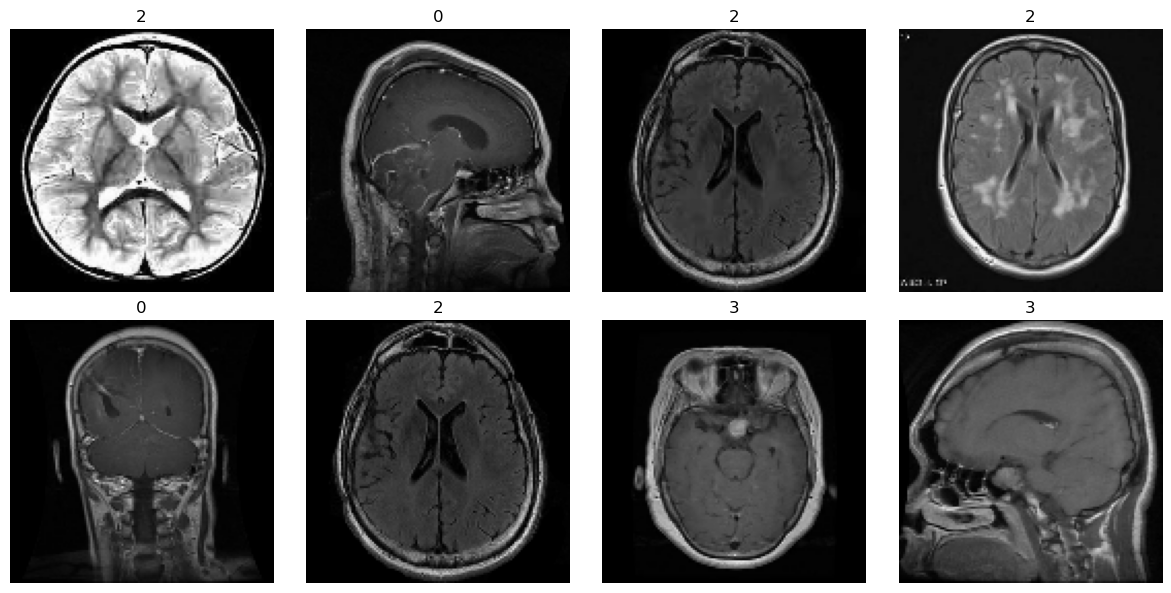

In [4]:
plt.figure(figsize=(12, 6))

for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.tight_layout()

In [8]:
from tensorflow.keras import layers, models
from tensorflow import keras

## Create a simple baseline CNN model

In [77]:
model = models.Sequential()

model.add(layers.Conv2D(16, (8, 8), activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (16, 16), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (16, 16), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(4, activation='softmax'))

In [78]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 121, 121, 16)      3088      
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 60, 60, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 45, 45, 32)        131104    
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 22, 22, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_38 (Conv2D)          (None, 7, 7, 64)          524352    
                                                                 
 flatten_8 (Flatten)         (None, 3136)            

In [79]:
model.compile(
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['sparse_categorical_accuracy']
              )

In [80]:
%%time
history = model.fit(
                    train_ds,
                    epochs = 30,
                    validation_data = val_ds,
                    )

Epoch 1/30
143/143 [==============================] - 4s 18ms/step - loss: 2.4629 - sparse_categorical_accuracy: 0.5823 - val_loss: 0.5984 - val_sparse_categorical_accuracy: 0.7408
Epoch 2/30
143/143 [==============================] - 2s 17ms/step - loss: 0.5872 - sparse_categorical_accuracy: 0.7744 - val_loss: 0.5028 - val_sparse_categorical_accuracy: 0.8109
Epoch 3/30
143/143 [==============================] - 2s 17ms/step - loss: 0.4396 - sparse_categorical_accuracy: 0.8341 - val_loss: 0.4540 - val_sparse_categorical_accuracy: 0.8319
Epoch 4/30
143/143 [==============================] - 2s 17ms/step - loss: 0.3165 - sparse_categorical_accuracy: 0.8792 - val_loss: 0.3926 - val_sparse_categorical_accuracy: 0.8529
Epoch 5/30
143/143 [==============================] - 2s 17ms/step - loss: 0.2502 - sparse_categorical_accuracy: 0.9083 - val_loss: 0.4451 - val_sparse_categorical_accuracy: 0.8739
Epoch 6/30
143/143 [==============================] - 2s 17ms/step - loss: 0.1771 - sparse_cate

In [69]:
y_true, y_pred = eval_model_on_test(model)

Found 1311 files belonging to 4 classes.


Predicting on Test Data:   0%|                                                                   | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 69ms/step


Predicting on Test Data:   9%|█████▎                                                     | 1/11 [00:00<00:04,  2.09it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  27%|████████████████                                           | 3/11 [00:00<00:01,  5.33it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  45%|██████████████████████████▊                                | 5/11 [00:00<00:00,  7.35it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  64%|█████████████████████████████████████▌                     | 7/11 [00:00<00:00,  8.72it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  82%|████████████████████████████████████████████████▎          | 9/11 [00:01<00:00,  9.70it/s]

1/1 [==============================] - 1s 976ms/step


Predicting on Test Data: 100%|██████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.81it/s]


In [70]:
y_pred_class = np.argmax(y_pred,1)

In [71]:
y_pred_class.shape

(1311,)

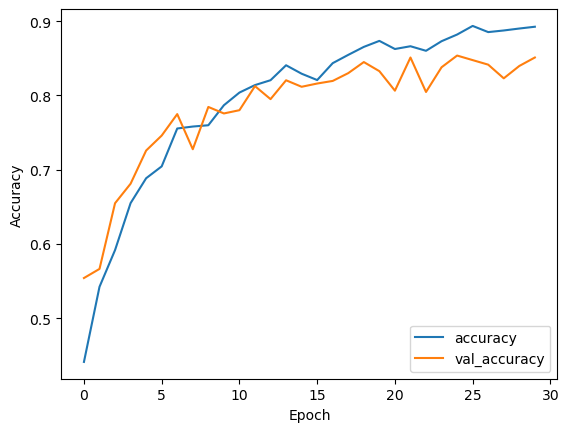

In [72]:
plt.plot(history.history['sparse_categorical_accuracy'], label='accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right');

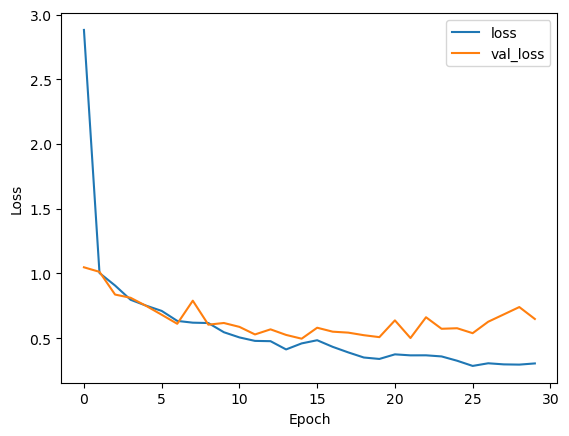

In [73]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right');

In [84]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [75]:
class_names=['glioma', 'meningioma', 'notumor', 'pituitary']

In [76]:
print(classification_report(y_true, y_pred_class, target_names=class_names))

              precision    recall  f1-score   support

      glioma       0.87      0.77      0.82       300
  meningioma       0.73      0.58      0.64       306
     notumor       0.90      0.91      0.91       405
   pituitary       0.73      0.95      0.83       300

    accuracy                           0.81      1311
   macro avg       0.81      0.80      0.80      1311
weighted avg       0.81      0.81      0.81      1311



In [88]:
print(confusion_matrix(y_true, y_pred_class))

[[232  52   0  16]
 [ 31 176  38  61]
 [  1   6 370  28]
 [  4   7   3 286]]


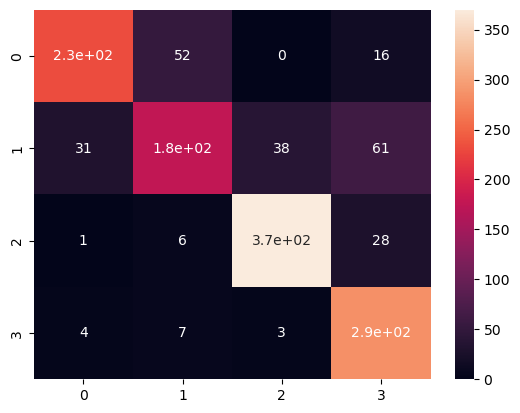

In [89]:
sns.heatmap(confusion_matrix(y_true, y_pred_class), annot=True);

## If you want to apply data augmentation operations on the train dataset

Go to the `prepare_train_and_val_datasets(...)` and you can add augmentation operations directly to the train dataset as follows:

```
train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                    .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=tf.data.AUTOTUNE))
```


Remember to check [`tf.image`](https://www.tensorflow.org/api_docs/python/tf/image#image_adjustments) for various image transforms available and you can play around with augmentations

__Be careful here and don't add too many transforms which can distort the images beyond recognition__